# **GSOC CERN-HSF GNN Tracking Qualification Task**

## Problem Statement

Task is to train an Edge Classifier Graph Neural Network to classify the edges (given by the edge_index) as true or false (given by the array y). The inputs to training/inference are x (the node features) and edge_features.

##Installing requirements


In [1]:
import torch; 
print(torch.__version__)
print(torch.version.cuda)

1.13.1+cu116
11.6


**Replace Torch and CUDA by respective versions in following code**


!pip install pyg_lib torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html <br>
!pip install torch-geometric

In [2]:
!pip install pyg_lib torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
# Command to move into directory of dataset on my system

In [17]:
cd drive/MyDrive/GSOC/CERN-HSF

/content/drive/MyDrive/GSOC/CERN-HSF


##Importing Required Libraries

In [19]:
import torch
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

## Data Loading

### Custom Dataset class. 

1. It recursively reads all the files ending with ```.pt extentsion``` in the home directory and the sub-directories. 
2. The data is then split into ```80/10/10 train-val-test split```. Can be changed.
3. Not all data is loaded into memory.

In [21]:
class MyDataset(Dataset):

    """
     It recursively reads all the files ending with .pt extentsion in the directory and the sub-directories. 
     The data is then split into 80/10/10 train-val-test split. Split ratio can be specified. Default value is set to 0.8 train size.
     Not all data is loaded into memory.
    """

    def __init__(self, path: Path, split_ratio = 0.2, split = 'train', random_seed = 1):
        super().__init__()

        # Recursively reading all .pth files from the directory and sub-directories
        self.data_list = list(path.glob("*/*[0-9].pt"))

        self.split_ratio = split_ratio
        self.split = split
        self.random_seed = random_seed
        
        # Split the data into training and test sets

        train_data_list, rem_data_list = train_test_split(self.data_list, test_size=split_ratio, random_state=random_seed)
        val_data_list, test_data_list = train_test_split(rem_data_list, test_size=0.5, random_state=random_seed)
        
        # Set the data list to the appropriate split

        if split == 'train':
            self.graphs = train_data_list
        elif split == 'test':
            self.graphs = test_data_list
        elif split == 'val':
            self.graphs = val_data_list
        else:
            raise ValueError(f"Invalid split: {split}")
      
    def __getitem__(self, idx):
        return torch.load(self.graphs[idx])
    
    def __len__(self) -> int:
        return len(self.graphs)

In [22]:
# Dataset should be available in present working directory
# Total 9996 graphs

train_dataset = MyDataset(Path("./"), split = 'train')
val_dataset = MyDataset(Path("./"), split = 'val')
test_dataset = MyDataset(Path("./"), split = 'test')

### Function to create DataLoader objects for each split


In [23]:
def get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32):

    """
    Function to create the DataLoaders for train-val-test data. 
    Can specify batch size. Default value is set to 32.
    """

    # Shuffle=True for training data to get diversity in batches at each training epoch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, 
                                                         test_dataset, batch_size=32)

In [24]:
# Number of graphs used for each split

print(len(train_dataset), len(test_dataset), len(val_dataset))

7996 1000 1000


### Set up device

In [25]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
device = get_device()
print(device)

cuda


# Model



### Model Architecture

1. GCNConv layers are used for message passing between nodes in the graph. We use **two GCNConv layers** to extract node features.

2. After message passing, we **concatenate the node features with the edge features** to get a combined feature vector for each edge.

3. We then apply **two fully connected layers** to classify the edges, with a ReLU activation function and dropout regularization.

In [27]:
class EdgeClassifier(nn.Module):

    """
    GNN network for edge classifcation. 
    Default parameters have node_features = 6, edge_features = 4, hidden_channels = 64, classes = 2

    2-hop GCN for node features aggregation with activation as ReLU.
    Followed by concatenation of the neighboring nodes of an edge with it's own features 
    to get a feature vector for each.
    Finally followed by linear layers and dropout.
    """

    def __init__(self, num_node_features = 6, num_edge_features = 4, hidden_channels = 64, num_classes = 2):
        super(EdgeClassifier, self).__init__()
        
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin1 = nn.Linear(num_edge_features + 2 * hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, num_classes)
    
    def forward(self, data):

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Aggreagation of Node features
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Concatenation of features of nodes and the edge between them
        x = torch.cat([x[edge_index[0]], x[edge_index[1]], edge_attr], dim=1)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)

        # No softmax since Cross-Entropy Loss also applies softmax

        return x

### Handling Data-Imbalance



The dataset contains two edge labels 0 and 1. Upon analysis I found the ratio for ```label1 : label0 is approximately 1 : 4```.

To handle this, I have given more weightage to loss occured by the minority class (here label1). 

The formula used is:

<center>weight1 = 1/(total samples * freq1)<br>
weight0 = 1/(total samples * freq0)</center>

In [28]:
def calculate_class_weights(train_loader):

    """
    Calculates weightage given to each sample in calculating loss by taking inverse of their frequency.
    Currently functional for binary labelled dataset.
    """

    # Counting frequency of edges having label as 1
    sum = 0
    total = 0
    for data in tqdm(train_loader):
        sum += data.y.sum().item()
        total += len(data.y)

    freq1 = sum/total
    freq0 = 1-freq1
    weight1 = 1/(total*freq1)
    weight0 = 1/(total*freq0)

    print(f'Frequency of class 0 : {freq0}, Assigned weight : {weight0}')
    print(f'Frequency of class 1 : {freq1}, Assigned weight : {weight1}')

    return torch.tensor([weight0, weight1]).to(get_device())

In [29]:
# Getting the weights

weights = calculate_class_weights(train_loader)

100%|██████████| 250/250 [1:22:18<00:00, 19.76s/it]


Frequency of class 0 : 0.8237903406190967, Assigned weight : 3.856839665466984e-08
Frequency of class 1 : 0.1762096593809033, Assigned weight : 1.8030948319695926e-07


### Creating the model and setting the optimizer and loss function

In [30]:
# Instantiating the model

model = EdgeClassifier(num_node_features=6, num_edge_features=4, hidden_channels=64, num_classes=2)
model = model.to(device)

# Adam is used as the optimizer with learning rate = 0.0001
# Loss function is CrossEntropyLoss with custom weights

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=weights)

### Defning Training and Validation functions

In [31]:
# Training the Model

def train(model, device, train_loader, optimizer, criterion):

    model.train()
    correct = 0
    total = 0
    total_loss = 0

    for data in tqdm(train_loader):

        data = data.to(device)
        optimizer.zero_grad()

        # Forward and Backward Propagation
        out = model(data)
        loss = criterion(out, data.y.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculation of correctly classified edges
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += len(pred)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total

    print(f'Train Loss : {train_loss:.4f}')
    print(f'Train Accuracy: {train_acc:.3f}')

    return model, train_loss

In [32]:
# Validation Function

def evaluate(model, device, loader):

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in tqdm(loader):

            data = data.to(device)
            out = model(data)

            # Calculation of correctly classified edges
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += len(pred)

        acc = correct / total
        print(f'Validation Accuracy {acc:.3f}')

### Traning the Model

In [33]:
# Training Loop

epochs = 20

for epoch in range(epochs):

  print(f'Epoch : {epoch+1} \n')

  model, loss = train(model, device, train_loader, optimizer, criterion)
  evaluate(model, device, val_loader)

  print('\n')

Epoch : 1 



100%|██████████| 250/250 [00:15<00:00, 16.14it/s]


Train Loss : 0.4901
Train Accuracy: 0.810


100%|██████████| 32/32 [10:07<00:00, 19.00s/it]


Validation Accuracy 0.827


Epoch : 2 



100%|██████████| 250/250 [00:14<00:00, 17.43it/s]


Train Loss : 0.3933
Train Accuracy: 0.841


100%|██████████| 32/32 [00:01<00:00, 20.37it/s]


Validation Accuracy 0.855


Epoch : 3 



100%|██████████| 250/250 [00:14<00:00, 17.38it/s]


Train Loss : 0.3658
Train Accuracy: 0.853


100%|██████████| 32/32 [00:01<00:00, 21.01it/s]


Validation Accuracy 0.858


Epoch : 4 



100%|██████████| 250/250 [00:14<00:00, 17.13it/s]


Train Loss : 0.3463
Train Accuracy: 0.870


100%|██████████| 32/32 [00:01<00:00, 20.88it/s]


Validation Accuracy 0.880


Epoch : 5 



100%|██████████| 250/250 [00:14<00:00, 17.27it/s]


Train Loss : 0.3336
Train Accuracy: 0.882


100%|██████████| 32/32 [00:01<00:00, 20.60it/s]


Validation Accuracy 0.898


Epoch : 6 



100%|██████████| 250/250 [00:14<00:00, 17.40it/s]


Train Loss : 0.3242
Train Accuracy: 0.889


100%|██████████| 32/32 [00:01<00:00, 19.93it/s]


Validation Accuracy 0.902


Epoch : 7 



100%|██████████| 250/250 [00:14<00:00, 17.62it/s]


Train Loss : 0.3127
Train Accuracy: 0.895


100%|██████████| 32/32 [00:01<00:00, 19.96it/s]


Validation Accuracy 0.895


Epoch : 8 



100%|██████████| 250/250 [00:14<00:00, 17.38it/s]


Train Loss : 0.2935
Train Accuracy: 0.900


100%|██████████| 32/32 [00:01<00:00, 20.77it/s]


Validation Accuracy 0.908


Epoch : 9 



100%|██████████| 250/250 [00:14<00:00, 17.16it/s]


Train Loss : 0.2683
Train Accuracy: 0.906


100%|██████████| 32/32 [00:01<00:00, 20.24it/s]


Validation Accuracy 0.913


Epoch : 10 



100%|██████████| 250/250 [00:14<00:00, 17.54it/s]


Train Loss : 0.2482
Train Accuracy: 0.909


100%|██████████| 32/32 [00:01<00:00, 20.05it/s]


Validation Accuracy 0.918


Epoch : 11 



100%|██████████| 250/250 [00:14<00:00, 17.43it/s]


Train Loss : 0.2314
Train Accuracy: 0.911


100%|██████████| 32/32 [00:01<00:00, 20.69it/s]


Validation Accuracy 0.915


Epoch : 12 



100%|██████████| 250/250 [00:14<00:00, 17.47it/s]


Train Loss : 0.2181
Train Accuracy: 0.912


100%|██████████| 32/32 [00:01<00:00, 20.41it/s]


Validation Accuracy 0.920


Epoch : 13 



100%|██████████| 250/250 [00:14<00:00, 17.58it/s]


Train Loss : 0.2075
Train Accuracy: 0.913


100%|██████████| 32/32 [00:01<00:00, 19.92it/s]


Validation Accuracy 0.921


Epoch : 14 



100%|██████████| 250/250 [00:14<00:00, 17.42it/s]


Train Loss : 0.1983
Train Accuracy: 0.914


100%|██████████| 32/32 [00:01<00:00, 19.92it/s]


Validation Accuracy 0.925


Epoch : 15 



100%|██████████| 250/250 [00:14<00:00, 17.72it/s]


Train Loss : 0.1906
Train Accuracy: 0.914


100%|██████████| 32/32 [00:01<00:00, 21.05it/s]


Validation Accuracy 0.921


Epoch : 16 



100%|██████████| 250/250 [00:13<00:00, 17.96it/s]


Train Loss : 0.1842
Train Accuracy: 0.915


100%|██████████| 32/32 [00:01<00:00, 20.70it/s]


Validation Accuracy 0.929


Epoch : 17 



100%|██████████| 250/250 [00:13<00:00, 17.90it/s]


Train Loss : 0.1785
Train Accuracy: 0.916


100%|██████████| 32/32 [00:01<00:00, 21.19it/s]


Validation Accuracy 0.924


Epoch : 18 



100%|██████████| 250/250 [00:13<00:00, 17.93it/s]


Train Loss : 0.1740
Train Accuracy: 0.916


100%|██████████| 32/32 [00:01<00:00, 20.99it/s]


Validation Accuracy 0.925


Epoch : 19 



100%|██████████| 250/250 [00:14<00:00, 17.49it/s]


Train Loss : 0.1694
Train Accuracy: 0.917


100%|██████████| 32/32 [00:01<00:00, 20.36it/s]


Validation Accuracy 0.920


Epoch : 20 



100%|██████████| 250/250 [00:14<00:00, 17.55it/s]


Train Loss : 0.1660
Train Accuracy: 0.918


100%|██████████| 32/32 [00:01<00:00, 20.68it/s]

Validation Accuracy 0.922




### Testing the model

In [34]:
# Testing function

def test(model, device, loader):

    model.eval()
    y_true = []
    y_probas = []
    y_pred = []

    with torch.no_grad():
        for data in tqdm(loader):

            data = data.to(device)
            out = model(data)
            
            y_true += data.y.cpu().numpy().tolist()
            y_pred += out.argmax(dim=1).cpu().numpy().tolist()  # absoulte predictions
            y_probas += out[:, 1].cpu().numpy().tolist()  # probability of class 1

    # Calculating few metrics

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision, recall, thresholds = precision_recall_curve(y_true, y_probas)
    area = auc(recall, precision)

    print('\nResults\n')
    print(f'Testing Accuracy {acc:.3f}')
    print(f'F1 score: {f1:.3f}')
    print(f'AUCPR: {area:.3f}\n')

    return acc, f1, precision, recall, area

In [35]:
# Function for plotting and saving the AUCPR curve
# AUCPR is used as metric and not ROC. 
# Since, if the dataset is highly imbalanced then FPR would be close to 0 since TN  would be very high. 

def plot_pr_curve(precision, recall, area, name='pr-curve'):

    plt.plot(recall, precision)

    plt.plot([1, 0], [0, 1], 'k--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve, AUC:{area:.3f}')
    plt.savefig(f'{name}.png')
    plt.show()

100%|██████████| 32/32 [04:19<00:00,  8.10s/it]



Results

Testing Accuracy 0.923
F1 score: 0.820
AUCPR: 0.942



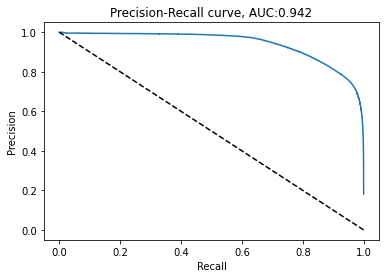

In [37]:
# Testing the Model 

acc, f1, precision, recall, area = test(model, device, test_loader)
plot_pr_curve(precision, recall, area)